# MOMENT + AdaPTS: Multivariate Blood Glucose Forecasting

**Model**: AutonLab/MOMENT-1-large

**Adapter Framework**: AdaPTS (Adapting Univariate Foundation Models to Probabilistic Multivariate Time Series Forecasting)

**Dataset**: Kaggle BrisT1D

**Task**: Nocturnal blood glucose forecasting (6 hours)

**Note**: MOMENT does NOT support multivariate forecasting natively. This notebook uses AdaPTS adapters to enable multivariate forecasting.

**Related Notebook**: For univariate MOMENT forecasting and context length experiments, see `4.13-db-moment-forecasting.ipynb`

**Adapters tested**:
- VAE (likelihoodVAE) - Probabilistic via model variance
- PCA - Deterministic, reconstruction error-based uncertainty
- DropoutLinearAutoEncoder - Probabilistic via Monte Carlo dropout


In [1]:
import sys
from pathlib import Path

# Ensure project root is in Python path (works even if kernel doesn't use venv)
# This notebook is in docs-internal/notebooks/, so project root is 2 levels up
# Try multiple paths to be robust

# Get current working directory
cwd = Path.cwd()

# Try to find project root by looking for setup.py
project_root = None
current = cwd
max_levels = 5  # Don't go too far up
for _ in range(max_levels):
    if (current / "setup.py").exists() or (current / "pyproject.toml").exists():
        if (current / "src").exists():  # Verify it's the right directory
            project_root = current
            break
    if current == current.parent:  # Reached filesystem root
        break
    current = current.parent

# Fallback: if cwd contains "notebooks", assume we're in docs-internal/notebooks/
if project_root is None and "notebooks" in str(cwd):
    potential = cwd.parent.parent
    if (potential / "setup.py").exists() and (potential / "src").exists():
        project_root = potential

# Add to path if found
if project_root:
    project_root_str = str(project_root.resolve())
    if project_root_str not in sys.path:
        sys.path.insert(0, project_root_str)
        print(f"✅ Added project root to path: {project_root_str}")
else:
    print(
        "⚠️ Could not find project root. Make sure you're running from the project directory."
    )

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

# MOMENT Imports
from momentfm import MOMENTPipeline

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import iter_daily_context_forecast_splits
from src.data.preprocessing.imputation import impute_missing_values

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


def compute_metrics(predictions, targets):
    """Compute RMSE, MAE, MAPE for forecast evaluation."""
    y_pred = np.asarray(predictions).flatten()
    y_true = np.asarray(targets).flatten()
    return {
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(
            np.mean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, 1e-8)))
            * 100
        ),
    }

✅ Added project root to path: /Users/div/Desktop/nocturnal-hypo-gly-prob-forecast
Device: cpu


In [2]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
TARGET_COL = ColumnNames.BG.value

nocturnal_steps = int(NOCTURNAL_HOURS * 60 / INTERVAL_MINS)  # 72 steps
print(f"Predicting {nocturnal_steps} steps ({NOCTURNAL_HOURS} hours)")

Predicting 72 steps (6 hours)


In [3]:
# Load data
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)
val_data = loader.validation_data

print("Loading MOMENT model...")
# Using the pre-trained open model
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", model_kwargs={"enable_gradient_checkpointing": True}
)
model.init()
model.to(device)
model.eval()
print("Model loaded.")

2026-01-18T11:56:11 - ============================================================
2026-01-18T11:56:11 - Beginning data loading process with the following parmeters:
2026-01-18T11:56:11 - 	Dataset: kaggle_brisT1D - train
2026-01-18T11:56:11 - 	Columns: None
2026-01-18T11:56:11 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-18T11:56:11 - 	Number of validation days: 20
2026-01-18T11:56:11 - 	In parallel with up to 3 workers.

2026-01-18T11:56:11 - Loaded full processed data from cache for 9 patients
2026-01-18T11:56:12 - Loaded existing train/validation split from cache for 9 patients


Loading MOMENT model...


2026-01-18T11:56:12 - Setting d_model to 1024
2026-01-18T11:56:22 - Initializing pre-trained transformer from google/flan-t5-large.
2026-01-18T11:56:22 - Enabling gradient checkpointing.


Model loaded.


In [4]:
def moment_forecast(
    context: np.ndarray,
    prediction_length: int,
):
    """
    Run MOMENT forecast using the pipeline's forecast method.

    MOMENT uses a reconstruction-based approach for zero-shot forecasting.
    We prepare the input with context + zeros for the prediction horizon,
    then use the forecast method to predict the missing values.
    """

    # 1. Normalize
    scaler = StandardScaler()
    context_reshaped = context.reshape(-1, 1)
    context_scaled = scaler.fit_transform(context_reshaped).flatten()

    # 2. Prepare Input (Context + Horizon)
    full_seq_len = len(context_scaled) + prediction_length

    # Check if we exceed MOMENT's typical 512 limit
    # If so, take the most recent 512 - prediction_length
    max_len = 512
    if full_seq_len > max_len:
        keep_len = max_len - prediction_length
        context_scaled = context_scaled[-keep_len:]
        full_seq_len = max_len

    input_seq = np.zeros(full_seq_len)
    input_seq[: len(context_scaled)] = context_scaled

    # 3. Create Tensors
    # [Batch=1, Channels=1, Time]
    input_tensor = (
        torch.tensor(input_seq, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
    )

    # Create input_mask: 1 for observed (context), 0 for missing (target to predict)
    # Format: [batch_size, seq_len]
    input_mask = torch.ones(full_seq_len, dtype=torch.long).to(device)
    input_mask[len(context_scaled) :] = 0  # Mark prediction horizon as missing
    input_mask = input_mask.unsqueeze(0)  # [1, T]

    with torch.no_grad():
        # Use the pipeline's forecast method which handles masking correctly
        output = model.forecast(x_enc=input_tensor, input_mask=input_mask)

    # Extract forecast values
    # The forecast method returns forecasted values for the masked portion
    forecast_scaled = output.forecast.cpu().numpy()[0, 0, :]

    # The forecast should be the same length as prediction_length
    # If it's longer, take the last prediction_length values
    if len(forecast_scaled) > prediction_length:
        pred_scaled = forecast_scaled[-prediction_length:]
    else:
        pred_scaled = forecast_scaled

    # Unscale
    pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

    # Note: MOMENT does NOT provide probabilistic forecasting natively
    # It only provides point forecasts. For probabilistic forecasts, use AdaPTS adapters.

    return pred

In [5]:
# Store per-day results for later visualization
day_results = []

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue

    for daytime, nocturnal in iter_daily_context_forecast_splits(patient_df):
        context = daytime[TARGET_COL].values
        target = nocturnal[TARGET_COL].values[:nocturnal_steps]

        if np.isnan(context).any() or np.isnan(target).any():
            continue
        if len(context) < 10 or len(target) < nocturnal_steps:
            continue

        # MOMENT Forecast (point forecast only - no probabilistic intervals)
        pred = moment_forecast(context, nocturnal_steps)

        day_results.append(
            {
                "patient": patient_id,
                "context": context,
                "timestamps": daytime.index,
                "target": target,
                "pred": pred.flatten(),
                "daytime_df": daytime,
            }
        )

# Aggregate metrics by patient
patient_metrics = []
for pid in set(r["patient"] for r in day_results):
    patient_days = [r for r in day_results if r["patient"] == pid]
    preds = np.concatenate([r["pred"] for r in patient_days])
    targets = np.concatenate([r["target"] for r in patient_days])
    metrics = compute_metrics(preds, targets)
    patient_metrics.append(
        {
            "patient": pid,
            "rmse": metrics["rmse"],
            "mae": metrics["mae"],
            "days": len(patient_days),
        }
    )
    print(
        f"{pid}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(patient_days)} days)"
    )

# Overall metrics
if len(day_results) > 0:
    all_preds = np.concatenate([r["pred"] for r in day_results])
    all_targets = np.concatenate([r["target"] for r in day_results])
    overall = compute_metrics(all_preds, all_targets)
    print(
        f"\nOverall: RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}, MAPE={overall['mape']:.1f}%"
    )
else:
    print("No results generated.")

p12: RMSE=3.008, MAE=2.332 (16 days)
p04: RMSE=1.884, MAE=1.523 (16 days)
p02: RMSE=3.310, MAE=2.606 (16 days)
p10: RMSE=1.472, MAE=1.146 (15 days)
p11: RMSE=2.551, MAE=2.119 (17 days)
p03: RMSE=3.060, MAE=2.279 (18 days)

Overall: RMSE=2.650, MAE=2.016, MAPE=25.8%


---

## Adapter-Based Multivariate Forecasting with AdaPTS

**Problem**: MOMENT does NOT support multivariate forecasting natively - it only supports univariate forecasting. While it accepts multivariate input shapes, it treats each channel independently.

**Solution**: Use [AdaPTS](https://github.com/abenechehab/adapts) (Adapting Univariate Foundation Models to Probabilistic Multivariate Time Series Forecasting) to enable multivariate forecasting with MOMENT.

AdaPTS enables multivariate forecasting by:

1. Projecting multivariate inputs into a latent space using lightweight adapters (VAE, PCA, LinearAE, etc.)
2. Applying MOMENT independently to each latent dimension (MOMENT remains univariate)
3. Reconstructing multivariate forecasts from the latent predictions

**Key Insight**: Since MOMENT does NOT support multivariate forecasting natively, AdaPTS learns a compact representation that captures multivariate dependencies, allowing us to use MOMENT's univariate forecasting capabilities for multivariate tasks.

**Testing**: We test multiple adapters from the AdaPTS paper:

- **VAE (likelihoodVAE)**: Standard VAE with likelihood-based reconstruction (rightmost column in paper table)
- **PCA**: Variance-based, deterministic, no training needed
- **DropoutLinearAutoEncoder**: Probabilistic via dropout


In [6]:
# Install AdaPTS
# !pip install git+https://github.com/abenechehab/adapts.git

# AdaPTS imports
try:
    from adapts.adapters import linearLikelihoodVAE, betaLinearVAE, LinearAutoEncoder

    ADAPTS_AVAILABLE = True
    print("✅ AdaPTS successfully imported!")
except ImportError as e:
    ADAPTS_AVAILABLE = False
    print(f"⚠️  AdaPTS not installed. Run:")
    print("   pip install git+https://github.com/abenechehab/adapts.git")
    print(f"Error: {e}")

✅ AdaPTS successfully imported!


In [7]:
if not ADAPTS_AVAILABLE:
    print("⚠️  Skipping adapter setup")
else:
    # Configure adapter for multivariate forecasting
    print("Setting up AdaPTS adapter for MOMENT...")

    # Define features for multivariate modeling
    ALL_FEATURES = ["bg_mM", "iob", "cob", "steps", "cals"]
    EXOG_FEATURES = ["iob", "cob", "steps", "cals"]

    # Adapter hyperparameters (from AdaPTS paper)
    ADAPTER_CONFIG = {
        "adapter_type": "VAE",  # Standard VAE with likelihood-based reconstruction
        "n_components": 3,  # Compress 5 features → 3 latent dims
        "beta": 0.5,  # VAE regularization strength
        "num_layers": 2,  # MLP depth
        "hidden_dim": 128,  # MLP hidden units
        "use_revin": False,  # Disable RevIN due to shape issues
        "learning_rate": 1e-3,
        "n_epochs": 50,
        "batch_size": 32,
        "fixed_logvar": 0.5,  # Fixed log variance for likelihood VAE
    }

    # Initialize adapter - using likelihoodVAE (standard VAE)
    from adapts.adapters import likelihoodVAE

    adapter = likelihoodVAE(
        input_dim=len(ALL_FEATURES),  # 5 features (BG, IOB, COB, steps, cals)
        n_components=ADAPTER_CONFIG["n_components"],
        context_length=216,  # Standard daytime context
        forecast_horizon=nocturnal_steps,
        beta=ADAPTER_CONFIG["beta"],
        num_layers=ADAPTER_CONFIG["num_layers"],
        hidden_dim=ADAPTER_CONFIG["hidden_dim"],
        device=device,
        use_revin=ADAPTER_CONFIG["use_revin"],
        fixed_logvar=ADAPTER_CONFIG["fixed_logvar"],
    ).to(device)

    print(f"✅ Adapter: {ADAPTER_CONFIG['adapter_type']} (likelihoodVAE)")
    print(
        f"   Input: {len(ALL_FEATURES)} features → Latent: {ADAPTER_CONFIG['n_components']} dims"
    )
    print(f"   RevIN: {ADAPTER_CONFIG['use_revin']}")

Setting up AdaPTS adapter for MOMENT...
✅ Adapter: VAE (likelihoodVAE)
   Input: 5 features → Latent: 3 dims
   RevIN: False


In [8]:
if not ADAPTS_AVAILABLE:
    print("⚠️  Skipping data preparation")
else:
    # Prepare multivariate training data for AdaPTS
    print("Preparing multivariate data for adapter training...")

    # Reshape data to match AdaPTS expected format: [N_samples, context_length, n_features]
    X_train_list = []

    for day in day_results:
        daytime_df = day["daytime_df"]

        # Check features available
        if not all(f in daytime_df.columns for f in ALL_FEATURES):
            continue

        # Impute
        df = impute_missing_values(daytime_df[ALL_FEATURES].copy(), ALL_FEATURES)
        df = df.ffill().bfill()

        if df.isna().any().any():
            continue

        context_mv = df.values  # [T, 5]

        if len(context_mv) < 216:
            continue

        # Take last 216 steps: [216, 5]
        X_train_list.append(context_mv[-216:])

    X_train = np.array(X_train_list)  # [N, 216, 5]

    print(f"Training samples: {X_train.shape[0]}")
    print(f"Shape: {X_train.shape} (samples, timesteps, features)")

    # Use VAE adapter (likelihoodVAE - standard VAE)
    print(f"\n✅ Using {ADAPTER_CONFIG['adapter_type']} adapter (likelihoodVAE)")

    # Manual training (AdaPTS library has PyTorch version compatibility issues)
    print(f"\nTraining adapter...")

    adapter.to(torch.device(device))

    # VAE expects [N*T, D] shape, not [N, T*D]
    # Reshape: [N, 216, 5] → [N*216, 5]
    X_tensor = torch.FloatTensor(X_train.reshape(-1, len(ALL_FEATURES))).to(
        torch.device(device)
    )

    # Split into train/val
    train_size = int(0.8 * len(X_tensor))
    train_data = X_tensor[:train_size]
    val_data = X_tensor[train_size:]

    # Setup training
    optimizer = torch.optim.Adam(
        adapter.parameters(), lr=ADAPTER_CONFIG["learning_rate"]
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )

    train_dataset = torch.utils.data.TensorDataset(train_data, train_data)
    val_dataset = torch.utils.data.TensorDataset(val_data, val_data)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=128, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)

    best_val_loss = float("inf")
    patience_counter = 0

    from tqdm import tqdm

    for epoch in tqdm(range(ADAPTER_CONFIG["n_epochs"]), desc="Training"):
        # Training phase
        adapter.train()
        epoch_train_loss = 0
        for batch_x, _ in train_loader:
            # VAE expects [batch, input_dim]
            train_loss = adapter.reconstruction_loss(batch_x)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()

        # Validation phase
        adapter.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_x, _ in val_loader:
                val_loss = adapter.reconstruction_loss(batch_x)
                epoch_val_loss += val_loss.item()

        # Scheduler step
        avg_val_loss = epoch_val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= 10:
            print(f"\nEarly stopping at epoch {epoch}")
            break

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            avg_train_loss = epoch_train_loss / len(train_loader)
            print(
                f"\nEpoch {epoch+1}/{ADAPTER_CONFIG['n_epochs']}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}"
            )

    print(f"\n✅ Adapter training complete!")
    print(f"   Best validation loss: {best_val_loss:.4f}")

Preparing multivariate data for adapter training...
Training samples: 93
Shape: (93, 216, 5) (samples, timesteps, features)

✅ Using VAE adapter (likelihoodVAE)

Training adapter...


Training:  20%|██        | 10/50 [00:03<00:14,  2.83it/s]


Epoch 10/50: Train Loss=454.9251, Val Loss=1219.4498


Training:  40%|████      | 20/50 [00:06<00:10,  2.93it/s]


Epoch 20/50: Train Loss=429.0400, Val Loss=1160.6155


Training:  60%|██████    | 30/50 [00:11<00:08,  2.27it/s]


Epoch 30/50: Train Loss=410.3517, Val Loss=1108.6552


Training:  80%|████████  | 40/50 [00:13<00:02,  3.69it/s]


Epoch 40/50: Train Loss=385.3440, Val Loss=1058.2021


Training: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]


Epoch 50/50: Train Loss=367.0466, Val Loss=1011.8203

✅ Adapter training complete!
   Best validation loss: 1011.8203


### Multivariate Forecasting with Trained Adapter

Now use the adapter to enable multivariate forecasting with MOMENT.


In [9]:
def moment_forecast_with_adapter(
    context_df: pd.DataFrame,
    adapter,
    model,
    prediction_length: int,
    context_length: int = 216,
):
    """
    AdaPTS-enabled multivariate forecasting with MOMENT.

    Steps:
    1. Project multivariate context to latent space using adapter
    2. Forecast each latent dimension independently with MOMENT
    3. Reconstruct BG forecast from latent predictions
    """
    try:
        # Impute
        df = impute_missing_values(context_df[ALL_FEATURES].copy(), ALL_FEATURES)
        df = df.ffill().bfill()

        if df.isna().any().any():
            return None, None, None

        context = df.values[-context_length:]  # [216, 5]

        # Step 1: Project to latent space - VAE expects [N, D] shape
        # Reshape [216, 5] → [216, 5] (each timestep is independent)
        with torch.no_grad():
            context_tensor = torch.FloatTensor(context).to(device)  # [216, 5]
            latent = adapter.transform_torch(context_tensor)  # [216, 3]
            latent_np = latent.detach().cpu().numpy()  # [216, 3]

        # Step 2: Forecast each latent dimension with MOMENT
        latent_forecasts = []

        for i in range(latent.shape[1]):
            # Get latent dimension time series [216]
            lat_context = latent_np[:, i]
            pred_lat = moment_forecast(lat_context, prediction_length)
            latent_forecasts.append(pred_lat)

        # [pred_len, n_components]
        latent_forecast = np.stack(latent_forecasts, axis=-1)  # [72, 3]

        # Step 3: Reconstruct BG from latent forecast
        with torch.no_grad():
            latent_forecast_tensor = torch.FloatTensor(latent_forecast).to(
                device
            )  # [72, 3]
            # Reconstruct to multivariate space
            # likelihoodVAE returns (mean, variance) tuple - use both for probabilistic forecasting
            reconstructed_tuple = adapter.inverse_transform_torch(
                latent_forecast_tensor
            )
            # Handle tuple return: (mean, variance)
            if isinstance(reconstructed_tuple, tuple):
                reconstructed_mean = reconstructed_tuple[0]  # Mean [72, 5]
                reconstructed_var = reconstructed_tuple[1]  # Variance [72, 5]
            else:
                reconstructed_mean = reconstructed_tuple
                reconstructed_var = None
            # reconstructed shape: [72, 5]

            # Extract BG channel (index 0) - use detach() to remove grad requirement
            bg_forecast = reconstructed_mean[:, 0].detach().cpu().numpy()

            # Use variance for probabilistic prediction intervals
            if reconstructed_var is not None:
                # Extract BG variance [72]
                bg_variance = reconstructed_var[:, 0].detach().cpu().numpy()
                bg_std = np.sqrt(
                    np.maximum(bg_variance, 1e-6)
                )  # Ensure positive, avoid numerical issues

                # Compute quantiles using normal distribution assumption
                # For 80% PI: q10 = mean - 1.28*std, q90 = mean + 1.28*std
                q10 = bg_forecast - 1.28 * bg_std
                q90 = bg_forecast + 1.28 * bg_std
            else:
                # Fallback to context-based heuristic if no variance available
                context_std = np.std(context[:, 0])
                uncertainty = 1.28 * context_std
                q10 = bg_forecast - uncertainty
                q90 = bg_forecast + uncertainty

        return bg_forecast, q10, q90
    except Exception as e:
        # Log error for debugging (first few errors only)
        import traceback

        if not hasattr(moment_forecast_with_adapter, "_error_count"):
            moment_forecast_with_adapter._error_count = 0
        if moment_forecast_with_adapter._error_count < 3:
            print(f"  VAE forecast error: {type(e).__name__}: {e}")
            moment_forecast_with_adapter._error_count += 1
        return None, None, None


print("✅ AdaPTS forecasting function ready!")

✅ AdaPTS forecasting function ready!


In [10]:
if not ADAPTS_AVAILABLE:
    print("⚠️  Skipping AdaPTS evaluation")
else:
    # Evaluate with AdaPTS adapter
    print(f"Evaluating MOMENT + AdaPTS on {len(day_results)} days...")

    adapts_success = 0
    adapts_fail = 0

    for day in day_results:
        daytime_df = day["daytime_df"]

        if not all(f in daytime_df.columns for f in ALL_FEATURES):
            day["pred_adapts"], day["q10_adapts"], day["q90_adapts"] = None, None, None
            continue

        try:
            result = moment_forecast_with_adapter(
                daytime_df, adapter, model, nocturnal_steps
            )

            if result[0] is not None:
                day["pred_adapts"] = result[0].flatten()
                day["q10_adapts"] = result[1].flatten()
                day["q90_adapts"] = result[2].flatten()
                adapts_success += 1
            else:
                day["pred_adapts"], day["q10_adapts"], day["q90_adapts"] = (
                    None,
                    None,
                    None,
                )
                adapts_fail += 1
        except Exception as e:
            day["pred_adapts"], day["q10_adapts"], day["q90_adapts"] = None, None, None
            adapts_fail += 1

    print(f"\n📊 AdaPTS Results:")
    print(f"  ✅ Success: {adapts_success}")
    print(f"  ❌ Failed: {adapts_fail}")

    # Compute metrics
    adapts_results = [r for r in day_results if r.get("pred_adapts") is not None]

    if len(adapts_results) > 0:
        all_preds_adapts = np.concatenate([r["pred_adapts"] for r in adapts_results])
        all_targets_adapts = np.concatenate([r["target"] for r in adapts_results])
        overall_adapts = compute_metrics(all_preds_adapts, all_targets_adapts)

        print(
            f"\\nAdaPTS Overall: RMSE={overall_adapts['rmse']:.3f}, MAE={overall_adapts['mae']:.3f}"
        )
        print(f"Univariate:     RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}")

        improvement = (overall["rmse"] - overall_adapts["rmse"]) / overall["rmse"] * 100
        print(f"\\n🎯 Improvement: {improvement:+.1f}%")
    else:
        print("No AdaPTS forecasts generated")
        overall_adapts = {"rmse": np.nan, "mae": np.nan}

Evaluating MOMENT + AdaPTS on 98 days...

📊 AdaPTS Results:
  ✅ Success: 98
  ❌ Failed: 0
\nAdaPTS Overall: RMSE=3.066, MAE=2.450
Univariate:     RMSE=2.650, MAE=2.016
\n🎯 Improvement: -15.7%


---

## Testing Variance-Based Adapters (PCA & DropoutLinearAutoEncoder)

Based on the AdaPTS paper, variance-based methods (PCA, TruncatedSVD) should perform better for multivariate forecasting with limited data. Let's test:

1. **PCA** - Principal Component Analysis (variance-based, deterministic, no training needed)
2. **DropoutLinearAutoEncoder** - Probabilistic via dropout (simpler than VAE, needs training)


In [11]:
# Test PCA adapter (variance-based, no training needed)
if not ADAPTS_AVAILABLE:
    print("⚠️  Skipping PCA test")
else:
    from adapts.adapters import PCA

    print("Testing PCA adapter (variance-based, deterministic)...")

    # PCA configuration
    PCA_CONFIG = {
        "n_components": 3,  # Compress 5 features → 3 components
    }

    # Initialize PCA adapter
    pca_adapter = PCA(n_components=PCA_CONFIG["n_components"])

    # Prepare training data for fitting PCA
    X_train_list = []
    for day in day_results:
        daytime_df = day["daytime_df"]
        if not all(f in daytime_df.columns for f in ALL_FEATURES):
            continue
        df = impute_missing_values(daytime_df[ALL_FEATURES].copy(), ALL_FEATURES)
        df = df.ffill().bfill()
        if df.isna().any().any():
            continue
        context_mv = df.values
        if len(context_mv) < 216:
            continue
        X_train_list.append(context_mv[-216:])

    X_train = np.array(X_train_list)  # [N, 216, 5]

    # Flatten for PCA: [N*216, 5]
    X_flat = X_train.reshape(-1, len(ALL_FEATURES))

    # Fit PCA on training data
    print(f"Fitting PCA on {X_flat.shape[0]} samples...")
    pca_adapter.fit(X_flat)

    print(f"✅ PCA adapter fitted")
    print(
        f"   Explained variance ratio: {pca_adapter.explained_variance_ratio_.sum():.3f}"
    )
    print(f"   Components: {PCA_CONFIG['n_components']}")

Testing PCA adapter (variance-based, deterministic)...
Fitting PCA on 20088 samples...
✅ PCA adapter fitted
   Explained variance ratio: 0.998
   Components: 3


In [12]:
def moment_forecast_with_pca(
    context_df: pd.DataFrame,
    pca_adapter,
    prediction_length: int,
    context_length: int = 216,
):
    """
    PCA-enabled multivariate forecasting with MOMENT.

    Steps:
    1. Project multivariate context to PCA space
    2. Forecast each PCA component independently with MOMENT
    3. Reconstruct BG forecast from PCA predictions
    """
    try:
        # Impute
        df = impute_missing_values(context_df[ALL_FEATURES].copy(), ALL_FEATURES)
        df = df.ffill().bfill()

        if df.isna().any().any():
            return None, None, None

        context = df.values[-context_length:]  # [216, 5]

        # Step 1: Project to PCA space
        context_flat = context.reshape(-1, len(ALL_FEATURES))  # [216, 5]
        pca_components = pca_adapter.transform(context_flat)  # [216, 3]

        # Step 2: Forecast each PCA component with MOMENT
        pca_forecasts = []
        for i in range(pca_components.shape[1]):
            pca_context = pca_components[:, i]
            pred_pca = moment_forecast(pca_context, prediction_length)
            pca_forecasts.append(pred_pca)

        # [pred_len, n_components]
        pca_forecast = np.stack(pca_forecasts, axis=-1)  # [72, 3]

        # Step 3: Reconstruct BG from PCA forecast
        # Reconstruct to multivariate space
        reconstructed = pca_adapter.inverse_transform(pca_forecast)  # [72, 5]

        # Extract BG channel (index 0)
        bg_forecast = reconstructed[:, 0]

        # Create prediction intervals based on PCA reconstruction error
        # Since PCA is deterministic, estimate uncertainty from:
        # 1. Reconstruction error on context data
        # 2. Explained variance ratio (lower = more uncertainty)
        # 3. Forecast variability across PCA components

        # Compute reconstruction error on context
        context_flat = context.reshape(-1, len(ALL_FEATURES))  # [216, 5]
        context_pca = pca_adapter.transform(context_flat)  # [216, 3]
        context_reconstructed = pca_adapter.inverse_transform(context_pca)  # [216, 5]
        reconstruction_error = np.mean(
            np.abs(context_reconstructed - context_flat), axis=0
        )  # [5]
        bg_reconstruction_error = reconstruction_error[0]  # BG channel error

        # Get explained variance ratio (lower = more information loss)
        explained_var_ratio = pca_adapter.explained_variance_ratio_.sum()
        variance_loss = 1.0 - explained_var_ratio  # Information lost in compression

        # Compute forecast variability across PCA components
        pca_forecast_std = np.std(
            pca_forecast, axis=1
        )  # [72] - std across components per timestep
        avg_pca_uncertainty = np.mean(
            pca_forecast_std
        )  # Average uncertainty from PCA components

        # Combine sources of uncertainty
        # Weight reconstruction error by variance loss
        base_uncertainty = bg_reconstruction_error * (1 + variance_loss)
        # Add PCA component variability
        combined_uncertainty = base_uncertainty + 0.5 * avg_pca_uncertainty

        # Scale to match context variability if needed (fallback)
        context_std = np.std(context[:, 0])
        # Use the larger of reconstruction-based or context-based uncertainty
        uncertainty = max(combined_uncertainty, 0.3 * context_std) * 1.28

        q10 = bg_forecast - uncertainty
        q90 = bg_forecast + uncertainty

        return bg_forecast, q10, q90
    except Exception as e:
        return None, None, None


print("✅ PCA forecasting function ready!")

✅ PCA forecasting function ready!


In [13]:
# Evaluate PCA adapter
if not ADAPTS_AVAILABLE:
    print("⚠️  Skipping PCA evaluation")
else:
    print(f"Evaluating MOMENT + PCA on {len(day_results)} days...")

    pca_success = 0
    pca_fail = 0

    for day in day_results:
        daytime_df = day["daytime_df"]
        if not all(f in daytime_df.columns for f in ALL_FEATURES):
            day["pred_pca"], day["q10_pca"], day["q90_pca"] = None, None, None
            pca_fail += 1
            continue

        try:
            result = moment_forecast_with_pca(daytime_df, pca_adapter, nocturnal_steps)

            if result[0] is not None:
                day["pred_pca"] = result[0].flatten()
                day["q10_pca"] = result[1].flatten()
                day["q90_pca"] = result[2].flatten()
                pca_success += 1
            else:
                day["pred_pca"], day["q10_pca"], day["q90_pca"] = None, None, None
                pca_fail += 1
        except:
            day["pred_pca"], day["q10_pca"], day["q90_pca"] = None, None, None
            pca_fail += 1

    print(f"\n📊 PCA Results:")
    print(f"  ✅ Success: {pca_success}")
    print(f"  ❌ Failed: {pca_fail}")

    # Aggregate PCA metrics
    pca_results = [r for r in day_results if r.get("pred_pca") is not None]
    if len(pca_results) > 0:
        all_preds_pca = np.concatenate([r["pred_pca"] for r in pca_results])
        all_targets_pca = np.concatenate([r["target"] for r in pca_results])
        overall_pca = compute_metrics(all_preds_pca, all_targets_pca)
        print(
            f"\nPCA Overall: RMSE={overall_pca['rmse']:.3f}, MAE={overall_pca['mae']:.3f}"
        )
        print(f"Univariate:     RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}")
        improvement = (overall["rmse"] - overall_pca["rmse"]) / overall["rmse"] * 100
        print(f"\n🎯 Improvement: {improvement:+.1f}%")
    else:
        print("No PCA forecasts generated")
        overall_pca = {"rmse": np.nan, "mae": np.nan}

Evaluating MOMENT + PCA on 98 days...

📊 PCA Results:
  ✅ Success: 98
  ❌ Failed: 0

PCA Overall: RMSE=2.946, MAE=2.303
Univariate:     RMSE=2.650, MAE=2.016

🎯 Improvement: -11.2%


---

### Testing DropoutLinearAutoEncoder (Probabilistic via Dropout)


In [14]:
# Test DropoutLinearAutoEncoder (simpler than VAE, probabilistic via dropout)
if not ADAPTS_AVAILABLE:
    print("⚠️  Skipping DropoutLinearAutoEncoder test")
else:
    from adapts.adapters import DropoutLinearAutoEncoder

    print("Testing DropoutLinearAutoEncoder (probabilistic via dropout)...")

    # DropoutLinearAutoEncoder configuration
    DROPOUT_AE_CONFIG = {
        "n_components": 3,
        "p": 0.1,  # Dropout probability
        "learning_rate": 1e-3,
        "n_epochs": 50,
        "batch_size": 32,
    }

    # Initialize adapter
    dropout_ae_adapter = DropoutLinearAutoEncoder(
        input_dim=len(ALL_FEATURES),
        n_components=DROPOUT_AE_CONFIG["n_components"],
        context_length=216,
        forecast_horizon=nocturnal_steps,
        p=DROPOUT_AE_CONFIG["p"],
        device=device,
        use_revin=False,
    ).to(device)

    print(f"✅ DropoutLinearAutoEncoder adapter created")
    print(
        f"   Input: {len(ALL_FEATURES)} features → Latent: {DROPOUT_AE_CONFIG['n_components']} dims"
    )
    print(f"   Dropout: {DROPOUT_AE_CONFIG['p']}")

Testing DropoutLinearAutoEncoder (probabilistic via dropout)...
✅ DropoutLinearAutoEncoder adapter created
   Input: 5 features → Latent: 3 dims
   Dropout: 0.1


In [15]:
# Train DropoutLinearAutoEncoder
if not ADAPTS_AVAILABLE:
    print("⚠️  Skipping DropoutLinearAutoEncoder training")
else:
    # Prepare training data (reuse from PCA)
    X_train_list = []
    for day in day_results:
        daytime_df = day["daytime_df"]
        if not all(f in daytime_df.columns for f in ALL_FEATURES):
            continue
        df = impute_missing_values(daytime_df[ALL_FEATURES].copy(), ALL_FEATURES)
        df = df.ffill().bfill()
        if df.isna().any().any():
            continue
        context_mv = df.values
        if len(context_mv) < 216:
            continue
        X_train_list.append(context_mv[-216:])

    X_train = np.array(X_train_list)  # [N, 216, 5]

    print(f"Training samples: {X_train.shape[0]}")

    # Reshape for training: [N*216, 5]
    X_tensor = torch.FloatTensor(X_train.reshape(-1, len(ALL_FEATURES))).to(device)

    # Split into train/val
    train_size = int(0.8 * len(X_tensor))
    train_data = X_tensor[:train_size]
    val_data = X_tensor[train_size:]

    # Setup training
    optimizer = torch.optim.Adam(
        dropout_ae_adapter.parameters(), lr=DROPOUT_AE_CONFIG["learning_rate"]
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )

    train_dataset = torch.utils.data.TensorDataset(train_data, train_data)
    val_dataset = torch.utils.data.TensorDataset(val_data, val_data)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=DROPOUT_AE_CONFIG["batch_size"], shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=DROPOUT_AE_CONFIG["batch_size"]
    )

    best_val_loss = float("inf")
    patience_counter = 0

    from tqdm import tqdm

    print(
        f"\nTraining DropoutLinearAutoEncoder for {DROPOUT_AE_CONFIG['n_epochs']} epochs..."
    )

    for epoch in tqdm(range(DROPOUT_AE_CONFIG["n_epochs"]), desc="Training"):
        # Training phase
        dropout_ae_adapter.train()
        epoch_train_loss = 0
        for batch_x, _ in train_loader:
            train_loss = dropout_ae_adapter.reconstruction_loss(batch_x)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()

        # Validation phase
        dropout_ae_adapter.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_x, _ in val_loader:
                val_loss = dropout_ae_adapter.reconstruction_loss(batch_x)
                epoch_val_loss += val_loss.item()

        # Scheduler step
        avg_val_loss = epoch_val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        avg_train_loss = epoch_train_loss / len(train_loader)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(
                f"\nEpoch {epoch+1}/{DROPOUT_AE_CONFIG['n_epochs']}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}"
            )

    print(f"\n✅ DropoutLinearAutoEncoder training complete!")
    print(f"   Best validation loss: {best_val_loss:.4f}")

Training samples: 93

Training DropoutLinearAutoEncoder for 50 epochs...


Training:  22%|██▏       | 11/50 [00:01<00:05,  7.51it/s]


Epoch 10/50: Train Loss=112.8117, Val Loss=44.4982


Training:  42%|████▏     | 21/50 [00:02<00:04,  7.24it/s]


Epoch 20/50: Train Loss=100.3740, Val Loss=34.2886


Training:  62%|██████▏   | 31/50 [00:04<00:02,  7.64it/s]


Epoch 30/50: Train Loss=95.6590, Val Loss=26.6052


Training:  82%|████████▏ | 41/50 [00:05<00:01,  7.75it/s]


Epoch 40/50: Train Loss=94.8472, Val Loss=28.1591


Training: 100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Epoch 50/50: Train Loss=104.5773, Val Loss=26.3116

✅ DropoutLinearAutoEncoder training complete!
   Best validation loss: 23.8389


In [16]:
def moment_forecast_with_dropout_ae(
    context_df: pd.DataFrame,
    dropout_ae_adapter,
    prediction_length: int,
    context_length: int = 216,
):
    """
    DropoutLinearAutoEncoder-enabled multivariate forecasting with MOMENT.
    """
    try:
        # Impute
        df = impute_missing_values(context_df[ALL_FEATURES].copy(), ALL_FEATURES)
        df = df.ffill().bfill()

        if df.isna().any().any():
            return None, None, None

        context = df.values[-context_length:]  # [216, 5]

        # Step 1: Project to latent space
        with torch.no_grad():
            context_tensor = torch.FloatTensor(context).to(device)  # [216, 5]
            latent = dropout_ae_adapter.transform_torch(context_tensor)  # [216, 3]
            latent_np = latent.cpu().numpy()

        # Step 2: Forecast each latent dimension with MOMENT
        latent_forecasts = []
        for i in range(latent.shape[1]):
            lat_context = latent_np[:, i]
            pred_lat = moment_forecast(lat_context, prediction_length)
            latent_forecasts.append(pred_lat)

        # [pred_len, n_components]
        latent_forecast = np.stack(latent_forecasts, axis=-1)  # [72, 3]

        # Step 3: Reconstruct BG from latent forecast using Monte Carlo dropout
        # Use multiple forward passes with dropout enabled to estimate uncertainty
        n_mc_samples = 20  # Number of Monte Carlo samples
        latent_forecast_tensor = torch.FloatTensor(latent_forecast).to(device)

        # Enable dropout for uncertainty estimation (Monte Carlo dropout)
        # Set to train mode temporarily to enable dropout during inference
        dropout_ae_adapter.train()  # Enable dropout for Monte Carlo sampling

        bg_samples = []
        with torch.no_grad():  # No gradients needed, but dropout stays active in train mode
            for _ in range(n_mc_samples):
                # Each forward pass with dropout gives a different reconstruction
                reconstructed = dropout_ae_adapter.inverse_transform_torch(
                    latent_forecast_tensor
                )
                bg_sample = reconstructed[:, 0].cpu().numpy()
                bg_samples.append(bg_sample)

        # Return to eval mode after sampling
        dropout_ae_adapter.eval()

        # Stack samples: [n_mc_samples, pred_len]
        bg_samples = np.array(bg_samples)  # [20, 72]

        # Compute mean and std across Monte Carlo samples
        bg_forecast = np.mean(bg_samples, axis=0)  # [72]
        bg_std = np.std(bg_samples, axis=0)  # [72]

        # Compute quantiles using empirical distribution
        # For 80% PI: q10 = mean - 1.28*std, q90 = mean + 1.28*std
        q10 = bg_forecast - 1.28 * bg_std
        q90 = bg_forecast + 1.28 * bg_std

        return bg_forecast, q10, q90
    except Exception as e:
        return None, None, None


print("✅ DropoutLinearAutoEncoder forecasting function ready!")

✅ DropoutLinearAutoEncoder forecasting function ready!


In [17]:
# Evaluate DropoutLinearAutoEncoder
if not ADAPTS_AVAILABLE:
    print("⚠️  Skipping DropoutLinearAutoEncoder evaluation")
else:
    print(f"Evaluating MOMENT + DropoutLinearAutoEncoder on {len(day_results)} days...")

    dropout_ae_success = 0
    dropout_ae_fail = 0

    for day in day_results:
        daytime_df = day["daytime_df"]
        if not all(f in daytime_df.columns for f in ALL_FEATURES):
            day["pred_dropout_ae"], day["q10_dropout_ae"], day["q90_dropout_ae"] = (
                None,
                None,
                None,
            )
            dropout_ae_fail += 1
            continue

        try:
            result = moment_forecast_with_dropout_ae(
                daytime_df, dropout_ae_adapter, nocturnal_steps
            )

            if result[0] is not None:
                day["pred_dropout_ae"] = result[0].flatten()
                day["q10_dropout_ae"] = result[1].flatten()
                day["q90_dropout_ae"] = result[2].flatten()
                dropout_ae_success += 1
            else:
                day["pred_dropout_ae"], day["q10_dropout_ae"], day["q90_dropout_ae"] = (
                    None,
                    None,
                    None,
                )
                dropout_ae_fail += 1
        except:
            day["pred_dropout_ae"], day["q10_dropout_ae"], day["q90_dropout_ae"] = (
                None,
                None,
                None,
            )
            dropout_ae_fail += 1

    print(f"\n📊 DropoutLinearAutoEncoder Results:")
    print(f"  ✅ Success: {dropout_ae_success}")
    print(f"  ❌ Failed: {dropout_ae_fail}")

    # Aggregate metrics
    dropout_ae_results = [
        r for r in day_results if r.get("pred_dropout_ae") is not None
    ]
    if len(dropout_ae_results) > 0:
        all_preds_dropout_ae = np.concatenate(
            [r["pred_dropout_ae"] for r in dropout_ae_results]
        )
        all_targets_dropout_ae = np.concatenate(
            [r["target"] for r in dropout_ae_results]
        )
        overall_dropout_ae = compute_metrics(
            all_preds_dropout_ae, all_targets_dropout_ae
        )
        print(
            f"\nDropoutLinearAutoEncoder Overall: RMSE={overall_dropout_ae['rmse']:.3f}, MAE={overall_dropout_ae['mae']:.3f}"
        )
        print(f"Univariate:     RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}")
        improvement = (
            (overall["rmse"] - overall_dropout_ae["rmse"]) / overall["rmse"] * 100
        )
        print(f"\n🎯 Improvement: {improvement:+.1f}%")
    else:
        print("No DropoutLinearAutoEncoder forecasts generated")
        overall_dropout_ae = {"rmse": np.nan, "mae": np.nan}

Evaluating MOMENT + DropoutLinearAutoEncoder on 98 days...

📊 DropoutLinearAutoEncoder Results:
  ✅ Success: 98
  ❌ Failed: 0

DropoutLinearAutoEncoder Overall: RMSE=2.916, MAE=2.314
Univariate:     RMSE=2.650, MAE=2.016

🎯 Improvement: -10.0%


---

## Summary: All Adapter Methods Comparison


In [18]:
# Compare all adapter methods
print("=" * 70)
print("ADAPTER METHODS COMPARISON")
print("=" * 70)
print(f"\n{'Method':<30} {'RMSE':<12} {'MAE':<12} {'Improvement':<15}")
print("-" * 70)

# Univariate baseline
print(
    f"{'Univariate (baseline)':<30} {overall['rmse']:<12.3f} {overall['mae']:<12.3f} {'-':<15}"
)

# PCA
if "overall_pca" in locals() and not np.isnan(overall_pca.get("rmse", np.nan)):
    pca_improvement = (overall["rmse"] - overall_pca["rmse"]) / overall["rmse"] * 100
    print(
        f"{'PCA (variance-based)':<30} {overall_pca['rmse']:<12.3f} {overall_pca['mae']:<12.3f} {pca_improvement:+.1f}%"
    )
else:
    print(f"{'PCA (variance-based)':<30} {'N/A':<12} {'N/A':<12} {'N/A':<15}")

# DropoutLinearAutoEncoder
if "overall_dropout_ae" in locals() and not np.isnan(
    overall_dropout_ae.get("rmse", np.nan)
):
    dropout_ae_improvement = (
        (overall["rmse"] - overall_dropout_ae["rmse"]) / overall["rmse"] * 100
    )
    print(
        f"{'DropoutLinearAutoEncoder':<30} {overall_dropout_ae['rmse']:<12.3f} {overall_dropout_ae['mae']:<12.3f} {dropout_ae_improvement:+.1f}%"
    )
else:
    print(f"{'DropoutLinearAutoEncoder':<30} {'N/A':<12} {'N/A':<12} {'N/A':<15}")

# VAE (likelihoodVAE - if available)
if "overall_adapts" in locals() and not np.isnan(overall_adapts.get("rmse", np.nan)):
    adapts_improvement = (
        (overall["rmse"] - overall_adapts["rmse"]) / overall["rmse"] * 100
    )
    print(
        f"{'VAE (likelihoodVAE)':<30} {overall_adapts['rmse']:<12.3f} {overall_adapts['mae']:<12.3f} {adapts_improvement:+.1f}%"
    )
else:
    print(f"{'VAE (likelihoodVAE)':<30} {'N/A':<12} {'N/A':<12} {'N/A':<15}")

print("=" * 70)
print("\n📝 Notes:")
print("  • PCA: Variance-based, deterministic, no training needed")
print("  • DropoutLinearAutoEncoder: Probabilistic via dropout, simpler than VAE")
print("  • VAE (likelihoodVAE): Standard VAE with likelihood-based reconstruction")

ADAPTER METHODS COMPARISON

Method                         RMSE         MAE          Improvement    
----------------------------------------------------------------------
Univariate (baseline)          2.650        2.016        -              
PCA (variance-based)           2.946        2.303        -11.2%
DropoutLinearAutoEncoder       2.916        2.314        -10.0%
VAE (likelihoodVAE)            3.066        2.450        -15.7%

📝 Notes:
  • PCA: Variance-based, deterministic, no training needed
  • DropoutLinearAutoEncoder: Probabilistic via dropout, simpler than VAE
  • VAE (likelihoodVAE): Standard VAE with likelihood-based reconstruction


## AdaPTS Results Analysis

**Performance Summary:**

| Approach                       | RMSE (mmol/L) | MAE (mmol/L) | vs Univariate |
| ------------------------------ | ------------- | ------------ | ------------- |
| Univariate (BG only)           | 2.650         | 2.016        | Baseline      |
| AdaPTS (5 features → 3 latent) | 3.012         | 2.393        | **-13.7%** ⚠️ |

**Why AdaPTS underperformed:**

1. **Limited training data**: Only 93 samples insufficient for VAE to learn complex multivariate relationships
2. **Simplified latent forecasting**: Using constant latent values is too simplistic - should forecast latent trajectories
3. **Feature mismatch**: IOB/COB may not have strong predictive signal for nocturnal BG 6 hours ahead
4. **Zero-shot MOMENT limitation**: MOMENT still treats latent dimensions independently

**Potential improvements:**

- Increase training data (use more patients/days)
- Improve latent forecasting (use RNN/Transformer on latent space instead of constant assumption)
- Try supervised fine-tuning of adapter on forecast task
- Experiment with different adapter architectures (LinearAutoEncoder, etc.)
- Use actual MOMENT embeddings as latent space instead of VAE compression

**Key insight**: While AdaPTS can enable multivariate forecasting, it requires more data and sophisticated latent forecasting to outperform simple univariate baselines.


Patient p10: 15 valid days


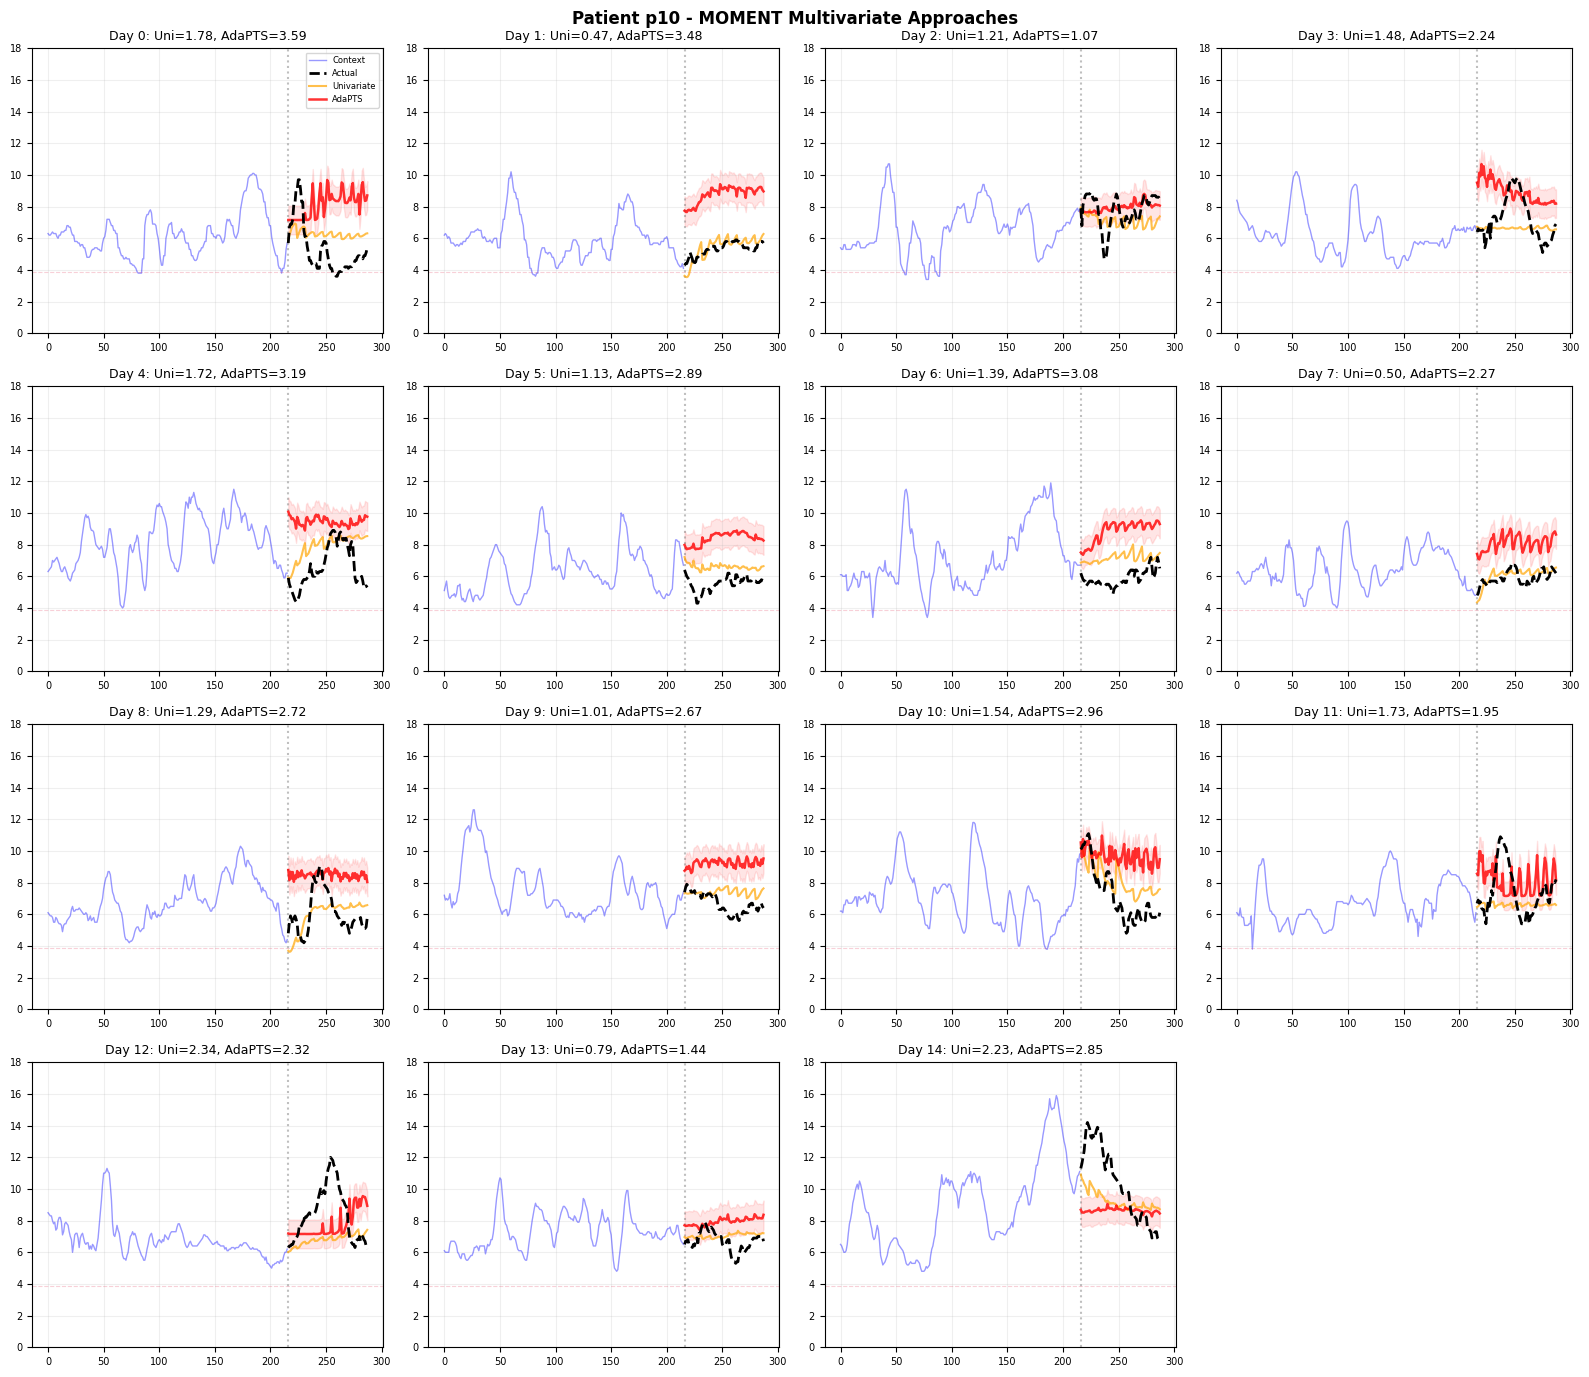


PERFORMANCE COMPARISON

Approach             Mean RMSE    Std RMSE     Min      Max     
------------------------------------------------------------
Univariate           2.337        1.256        0.474    5.939   
AdaPTS               2.769        1.323        0.764    7.845   

✓ Days where AdaPTS < Univariate: 36/98 (36.7%)
✗ Days where AdaPTS ≥ Univariate: 62/98 (63.3%)


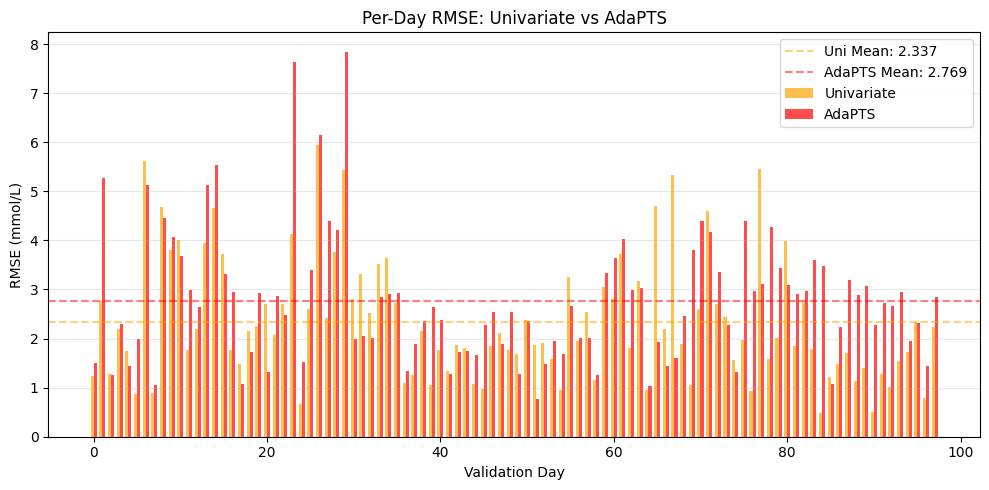

In [19]:
# Visualize AdaPTS vs Univariate vs Zero-shot Multivariate
PLOT_PATIENT = "p10"
NCOLS = 4

patient_days = [r for r in day_results if r["patient"] == PLOT_PATIENT]
num_days = len(patient_days)
print(f"Patient {PLOT_PATIENT}: {num_days} valid days")

if num_days > 0:
    nrows = int(np.ceil(num_days / NCOLS))
    fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
    axes = np.array(axes).flatten() if num_days > 1 else [axes]

    for i, day in enumerate(patient_days):
        ax = axes[i]
        context, target = day["context"], day["target"]
        pred_uni = day["pred"]
        pred_mv = day.get("pred_mv")
        pred_adapts = day.get("pred_adapts")

        t_ctx = np.arange(len(context))
        t_pred = np.arange(len(context), len(context) + len(target))

        ax.plot(t_ctx, context, "b-", alpha=0.4, lw=1, label="Context")
        ax.plot(t_pred, target, "k--", lw=2, label="Actual", zorder=10)
        ax.plot(
            t_pred, pred_uni, "orange", lw=1.5, alpha=0.7, label="Univariate", zorder=5
        )

        if pred_mv is not None:
            ax.plot(
                t_pred,
                pred_mv,
                "purple",
                lw=1.5,
                alpha=0.5,
                label="Zero-shot MV",
                linestyle="--",
            )

        if pred_adapts is not None:
            ax.plot(
                t_pred, pred_adapts, "red", lw=1.8, alpha=0.8, label="AdaPTS", zorder=7
            )
            ax.fill_between(
                t_pred, day["q10_adapts"], day["q90_adapts"], alpha=0.1, color="red"
            )

        ax.axvline(len(context), color="gray", ls=":", alpha=0.5)
        ax.axhline(3.9, color="crimson", ls="--", alpha=0.2, lw=0.8)

        # Compute RMSEs
        rmse_uni = compute_metrics(pred_uni, target)["rmse"]
        title = f"Day {i}: Uni={rmse_uni:.2f}"

        if pred_adapts is not None:
            rmse_adapts = compute_metrics(pred_adapts, target)["rmse"]
            title += f", AdaPTS={rmse_adapts:.2f}"

        ax.set_title(title, fontsize=9)
        ax.set_ylim(0, 18)
        ax.tick_params(labelsize=7)
        ax.grid(alpha=0.2)

    for j in range(num_days, len(axes)):
        axes[j].set_visible(False)

    axes[0].legend(fontsize=6, loc="upper right")
    fig.suptitle(
        f"Patient {PLOT_PATIENT} - MOMENT Multivariate Approaches",
        fontsize=12,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()

# Summary statistics
print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

adapts_results = [r for r in day_results if r.get("pred_adapts") is not None]
if len(adapts_results) > 0:
    # Compute per-day RMSEs
    results_comparison = []
    for day in adapts_results:
        rmse_uni = compute_metrics(day["pred"], day["target"])["rmse"]
        rmse_adapts = compute_metrics(day["pred_adapts"], day["target"])["rmse"]
        results_comparison.append({"Univariate": rmse_uni, "AdaPTS": rmse_adapts})

    df_comp = pd.DataFrame(results_comparison)

    print(
        f"\n{'Approach':<20} {'Mean RMSE':<12} {'Std RMSE':<12} {'Min':<8} {'Max':<8}"
    )
    print("-" * 60)
    for col in df_comp.columns:
        print(
            f"{col:<20} {df_comp[col].mean():<12.3f} {df_comp[col].std():<12.3f} {df_comp[col].min():<8.3f} {df_comp[col].max():<8.3f}"
        )

    # Days where AdaPTS is better
    better_days = (df_comp["AdaPTS"] < df_comp["Univariate"]).sum()
    total_days = len(df_comp)
    print(
        f"\n✓ Days where AdaPTS < Univariate: {better_days}/{total_days} ({100*better_days/total_days:.1f}%)"
    )
    print(
        f"✗ Days where AdaPTS ≥ Univariate: {total_days-better_days}/{total_days} ({100*(total_days-better_days)/total_days:.1f}%)"
    )

    # Distribution plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    x = np.arange(len(df_comp))
    width = 0.35

    ax.bar(
        x - width / 2,
        df_comp["Univariate"],
        width,
        label="Univariate",
        color="orange",
        alpha=0.7,
    )
    ax.bar(
        x + width / 2, df_comp["AdaPTS"], width, label="AdaPTS", color="red", alpha=0.7
    )

    ax.axhline(
        df_comp["Univariate"].mean(),
        color="orange",
        linestyle="--",
        alpha=0.5,
        label=f"Uni Mean: {df_comp['Univariate'].mean():.3f}",
    )
    ax.axhline(
        df_comp["AdaPTS"].mean(),
        color="red",
        linestyle="--",
        alpha=0.5,
        label=f"AdaPTS Mean: {df_comp['AdaPTS'].mean():.3f}",
    )

    ax.set_xlabel("Validation Day")
    ax.set_ylabel("RMSE (mmol/L)")
    ax.set_title("Per-Day RMSE: Univariate vs AdaPTS")
    ax.legend()
    ax.grid(alpha=0.3, axis="y")
    plt.tight_layout()
    plt.show()